In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

In [130]:
df_month_data = pd.read_csv("Cst_to_U_Sorted.csv",index_col=False,encoding="utf-8")
alpha = 0.5
destination = 'Uppsala c' 

In [131]:
def create_adjacency_matrix(df, destination_station=None):
    """
    Create an adjacency matrix from travel records
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing travel records
    destination_station (str, optional): Final destination station to exclude
    
    Returns:
    pandas.DataFrame: Adjacency matrix of stations
    """
    # Extract all stations except the destination station
    all_departure_stations = set(df['Avgångsplats'])
    all_arrival_stations = set(df['Ankomstplats'])
    
    # Combine all stations and remove destination station if specified
    all_stations = list(all_departure_stations.union(all_arrival_stations))
    if destination_station in all_stations:
        all_stations.remove(destination_station)
    
    # Create empty adjacency matrix
    n = len(all_stations)
    init_matrix = np.full((n, n), 0)
    adj_matrix = pd.DataFrame(init_matrix,
                              index=all_stations, columns=all_stations)
    
    # Fill adjacency matrix
    for _, row in df.iterrows():
        dep_station = row['Avgångsplats']
        arr_station = row['Ankomstplats']
        
        # Skip connections involving the destination station
        if dep_station == destination_station or arr_station == destination_station:
            continue
        
        # Mark connection between departure and arrival stations
        if dep_station in all_stations and arr_station in all_stations:
            adj_matrix.loc[dep_station, arr_station] = 1
    
    return adj_matrix,all_stations

In [132]:
def plot_adjacency_matrix(adj_matrix, station_names):
    """
    Plot the adjacency matrix using seaborn heatmap.
    
    Parameters:
    adj_matrix (numpy.ndarray): The adjacency matrix
    station_names (list): List of station names
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(adj_matrix, cmap='Blues', 
                xticklabels=station_names, 
                yticklabels=station_names,
                linewidths=0.5,
                linecolor='lightgray')
    plt.title('Station Connectivity Adjacency Matrix')
    plt.xlabel('To Station')
    plt.ylabel('From Station')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

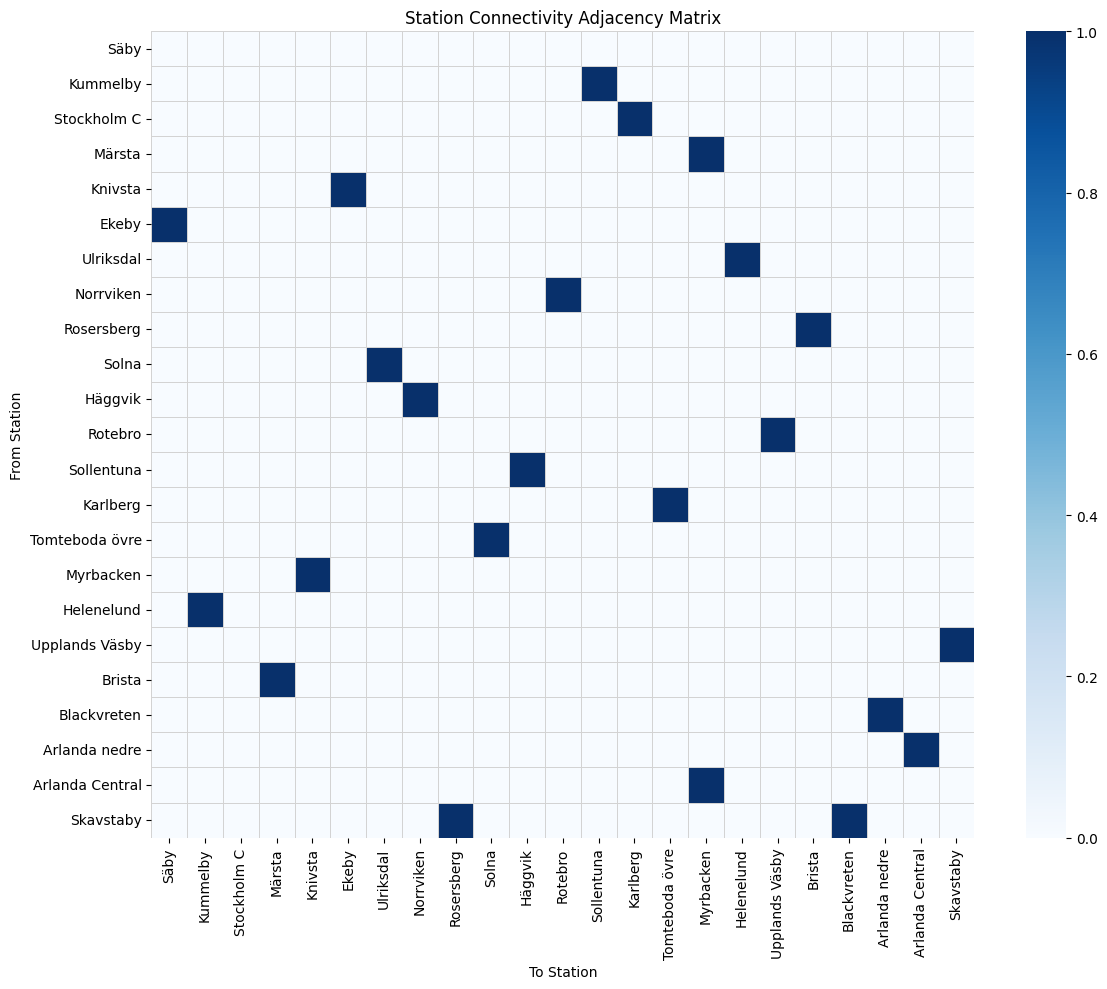

In [133]:
adj_max, all_stations = create_adjacency_matrix(df_month_data,destination)
plot_adjacency_matrix(adj_max, all_stations)

In [134]:
def create_delay_adjacency_matrix(df, adjacency_matrix, destination_station):
    """
    Create a delay adjacency matrix and vector based on an existing adjacency matrix
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing travel records with 'AvgFörsening' column
    adjacency_matrix (pandas.DataFrame): Existing adjacency matrix showing connected stations
    destination_station (str): Final destination station
    
    Returns:
    tuple: (delay_matrix, delay_vector)
        - delay_matrix: pandas.DataFrame with average delays between adjacent stations
        - delay_vector: pandas.Series with average delays between stations and destination
    """
    # Get the list of stations (excluding destination)
    stations = adjacency_matrix.index.tolist()
    
    init_delay_matrix = np.full((len(stations), len(stations)), np.inf)
    #np.fill_diagonal(init_delay_matrix, 100)
    # Create empty delay matrix with same dimensions as adjacency matrix
    delay_matrix = pd.DataFrame(init_delay_matrix,
                               index=stations, columns=stations)
    
    # Create delay vector for connections to destination
    init_delay_vector = np.full(len(stations), np.inf)
    delay_vector = pd.Series(init_delay_vector, index=stations)
    
    # --- CVaR for adjacent stations ---
    for i, stationi in enumerate(stations):
        for j, stationj in enumerate(stations):
            if adjacency_matrix.loc[stationi, stationj] == 1:
                delays = df[
                    (df['Avgångsplats'] == stationi) & 
                    (df['Ankomstplats'] == stationj)
                ]['AvgFörsening'].dropna()
                
                # Filter only non-negative delays
                delays = delays[delays >= 0]
                
                if not delays.empty:
                    var = np.quantile(delays, alpha)
                    tail = delays[delays >= var]
                    cvar = tail.mean() if not tail.empty else 0
                    delay_matrix.loc[stationi, stationj] = cvar

    # --- CVaR for destination vector ---
    for station in stations:
        delays = df[
            (df['Avgångsplats'] == station) & 
            (df['Ankomstplats'] == destination_station)
        ]['AvgFörsening'].dropna()
        
        delays = delays[delays >= 0]
        
        if not delays.empty:
            var = np.quantile(delays, alpha)
            tail = delays[delays >= var]
            cvar = tail.mean() if not tail.empty else 0
            delay_vector[station] = cvar

    # Fill delay matrix for adjacent stations
    #for i, stationi in enumerate(stations):
        #for j, stationj in enumerate(stations):
            # Check if stations are adjacent according to adjacency matrix
            #if adjacency_matrix.loc[stationi, stationj] == 1:
                # Get records for travels between these stations
                #station_travels = df[(df['Avgångsplats'] == stationi) & 
                                    #(df['Ankomstplats'] == stationj)]
                
                
                #if not station_travels.empty:
                    # Calculate average delay for this connection
                    #df_filtered_travels = station_travels[station_travels['AvgFörsening'] > alpha]
                    # df_filtered_travels['AvgFörsening'] = df_filtered_travels['AvgFörsening'].apply(lambda x: max(0, x))
                    #avg_delay = df_filtered_travels['AvgFörsening'].mean()
                    #if(pd.isna(avg_delay)):
                        #avg_delay = 0
                    #delay_matrix.loc[stationi, stationj] = avg_delay
    
    # Fill delay vector for connections to destination
    #for station in stations:
        # Get records for travels between station and destination
        #destination_travels = df[(df['Avgångsplats'] == station) & 
                                #(df['Ankomstplats'] == destination_station)]
        
        #if not destination_travels.empty:
            # Calculate average delay for this connection to destination
            #df_filtered_travels = destination_travels[destination_travels['AvgFörsening'] > alpha]
            #avg_delay = df_filtered_travels['AvgFörsening'].mean()
            #if(pd.isna(avg_delay)):
                #avg_delay = 0
            #delay_vector[station] = avg_delay
            
    return delay_matrix, delay_vector
   

In [135]:
def plot_combined_delay_analysis(delay_matrix, delay_vector, destination_station, figsize=(16, 12)):
    """
    Create a combined visualization with both delay matrix and vector
    
    Parameters:
    delay_matrix (pandas.DataFrame): Matrix containing average delays between stations
    delay_vector (pandas.Series): Vector containing average delays to destination
    destination_station (str): Name of the destination station
    figsize (tuple): Figure size as (width, height)
    
    Returns:
    matplotlib.figure.Figure: The figure object containing the plots
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot the delay matrix on the first subplot
    plt.sca(ax1)
    plot_matrix = delay_matrix.copy().replace(0, np.nan)
    sns.heatmap(plot_matrix, 
                cmap=sns.color_palette("YlOrRd", as_cmap=True),
                annot=True,
                fmt=".1f",
                linewidths=0.5,
                square=True,
                mask=plot_matrix.isna(),
                cbar_kws={'label': 'Average Delay (minutes)'})
    plt.title(f'Delay Matrix Between Stations', fontsize=16, pad=20)
    plt.xlabel('Arrival Station', fontsize=12, labelpad=10)
    plt.ylabel('Departure Station', fontsize=12, labelpad=10)
    plt.xticks(rotation=45, ha='right')
    
    # Plot the delay vector on the second subplot
    plt.sca(ax2)
    plot_vector = delay_vector[delay_vector > 0].sort_values(ascending=False)
    colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(plot_vector)))
    ax2.barh(plot_vector.index, plot_vector.values, color=colors)
    
    # Add value labels
    for i, v in enumerate(plot_vector.values):
        ax2.text(v + 0.1, i, f'{v:.1f}', va='center')
    
    plt.title(f'Average Delays to {destination_station}', fontsize=16, pad=20)
    plt.xlabel('Average Delay (minutes)', fontsize=12)
    plt.ylabel('Departure Station', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

In [136]:
delayed_adjacent_matrix, delayed_vector = create_delay_adjacency_matrix(df_month_data, adj_max, destination)
print(delayed_adjacent_matrix, delayed_vector)

df_check = df_month_data[(df_month_data['Avgångsplats'] == 'Hökmora') & (df_month_data['Ankomstplats'] == 'Avesta Krylbo')]
print(df_check[['Avgångsplats', 'Ankomstplats', 'AvgFörsening']])

# plot_combined_delay_analysis(delayed_adjacent_matrix, delayed_vector, destination)

                     Säby  Kummelby  Stockholm C    Märsta   Knivsta  \
Säby                  inf       inf          inf       inf       inf   
Kummelby              inf       inf          inf       inf       inf   
Stockholm C           inf       inf          inf       inf       inf   
Märsta                inf       inf          inf       inf       inf   
Knivsta               inf       inf          inf       inf       inf   
Ekeby            4.694268       inf          inf       inf       inf   
Ulriksdal             inf       inf          inf       inf       inf   
Norrviken             inf       inf          inf       inf       inf   
Rosersberg            inf       inf          inf       inf       inf   
Solna                 inf       inf          inf       inf       inf   
Häggvik               inf       inf          inf       inf       inf   
Rotebro               inf       inf          inf       inf       inf   
Sollentuna            inf       inf          inf       inf      

In [137]:
def create_cost_matrix(delayed_adjacent_matrix, delayed_vector, n_stations):
    # Part 1: Combine adjacency matrix and delayed_vector
    all_delayed_adj_matrix = np.concatenate([
        delayed_adjacent_matrix.to_numpy(), 
        delayed_vector.to_numpy().reshape(-1, 1)
    ], axis=1)
    
    # Part 2: Add absorbing state row (destination)
    cost_matrix = np.zeros((n_stations + 1, n_stations + 1))
    cost_matrix[:n_stations, :n_stations] = delayed_adjacent_matrix.to_numpy()
    cost_matrix[:n_stations, n_stations] = delayed_vector.to_numpy()
    
    # Enforce absorbing state
    cost_matrix[n_stations, :] = np.inf  # All outgoing edges = inf
    cost_matrix[n_stations, n_stations] = np.inf  # cost at destination is infinity
    
    # Replace inf with large finite value (optional, for stability)
    #cost_matrix = np.where(np.isinf(cost_matrix), 1e10, cost_matrix)

    # sec_matrix = np.zeros((n_stations+1,n_stations+1))
    # np.fill_diagonal(sec_matrix,10)

    return cost_matrix

In [138]:
cost_matrix = create_cost_matrix(delayed_adjacent_matrix,delayed_vector,len(all_stations))

In [139]:
pd.DataFrame(cost_matrix)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,4.549738
1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,1.817444,inf,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,inf,inf,3.707566,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
5,4.694268,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,2.517094,inf,inf,inf,inf,inf,inf,inf
7,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
8,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,4.763514,inf,inf,inf,inf,inf
9,inf,inf,inf,inf,inf,inf,1.936306,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [140]:
import numpy as np
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import eigsh, spsolve

def randomized_shortest_path_akamatsu(cost_matrix, source, destination, theta=1, max_iter=100000, tol=1e-6):

    n = cost_matrix.shape[0]
    W = np.exp(-theta * cost_matrix)
    #W[np.isinf(cost_matrix)] = 0  # Set non-edges to 0
    
    # Step 1: Check spectral radius (ρ(W) < 1)
    if n <= 1000:  # For small matrices, compute directly
        spectral_radius = np.max(np.abs(np.linalg.eigvals(W)))
    else:  # For large matrices, use sparse eigenvalue solver
        W_sparse = csr_matrix(W)
        spectral_radius = eigsh(W_sparse, k=1, return_eigenvectors=False)[0]
    print(spectral_radius)

    if spectral_radius >= 1:
        raise ValueError("Spectral radius condition violated: ρ(W) >= 1.")
    
    # Step 2: Solve (I - W) z_n = e_n iteratively (efficient for large/sparse W)
    e_n = np.zeros(n)
    e_n[destination] = 1
    z_n = np.zeros(n)  # Initial guess
    
    for _ in range(max_iter):
        z_new = W @ z_n + e_n
        if np.linalg.norm(z_new - z_n) < tol:
            break
        z_n = z_new
    else:
        print("Warning: Iterative solver did not converge. Consider increasing max_iter.")
    
    # Step 3: Compute transition probabilities P
    P = np.zeros((n, n))
    
    for k in range(n):
        if k == destination:
            P[k, k] = 1.0  # Absorbing state
        else:
            successors = np.where(cost_matrix[k, :] < np.inf)[0]
            if len(successors) == 0:
                continue  # Isolated node (no outgoing edges)
            
            # Compute P[k, k'] = (z_n[k'] / z_n[k]) * exp(-θ * cost[k, k'])
            for k_prime in successors:
                denom = max(z_n[k], 1e-12)  # avoid division by 0 or near-zero
                P[k, k_prime] = (z_n[k_prime] / denom) * np.exp(-theta * cost_matrix[k, k_prime])

                #if z_n[k] > 0:
                    #P[k, k_prime] = (z_n[k_prime] / z_n[k]) * np.exp(-theta * cost_matrix[k, k_prime])
                #else:
                    #P[k, k_prime] = 0  # Fallback (should not happen if ρ(W) < 1)
            
            # Normalize to ensure probabilities sum to 1
            row_sum = np.sum(P[k, :])
            if row_sum > 0:
                P[k, :] /= row_sum
            else:
                P[k, successors] = 1.0 / len(successors)  # Uniform fallback
    
    return P

In [141]:

prob = pd.DataFrame(randomized_shortest_path_akamatsu(cost_matrix,0,11))
prob

0.0


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
prob.loc[0].sum()

np.float64(1.0)

In [143]:
def randomized_shortest_path(cost_matrix, source, destination, theta=1.0):
    """
    Compute the optimal randomized shortest path policy using Akamatsu's model.
    
    Args:
        cost_matrix: n x n matrix of immediate costs between nodes
        source: index of the source node (0-based)
        destination: index of the destination node (0-based)
        theta: parameter controlling the degree of exploration (higher = more exploration)
        
    Returns:
        Transition probability matrix P
    """
    n = cost_matrix.shape[0]
    
    # Step 1: Compute W matrix (elementwise exponential of -theta * cost_matrix)
    W = np.exp(-theta * cost_matrix)
    
    # Step 2: Check spectral radius condition (simplified check)
    # In practice, for large matrices, computing spectral radius is expensive
    # So we'll just proceed and handle numerical issues if they arise
    
    # Step 5: Solve (I - W)z_n = e_n for z_n
    I = np.eye(n)
    e_n = np.zeros(n)
    e_n[destination] = 1
    
    # Using sparse solver if matrix is large
    if n > 1000:
        W_sparse = csr_matrix(W)
        I_sparse = csr_matrix(I)
        A = I_sparse - W_sparse
        z_n = spsolve(A, e_n)
    else:
        z_n = np.linalg.solve(I - W, e_n)
    
    # Step 6: Compute transition probabilities
    P = np.zeros((n, n))
    
    for k in range(n):
        if k == destination:
            # Absorbing state - stay with probability 1
            P[k, k] = 1.0
        else:
            # Get successors (nodes with finite cost)
            successors = np.where(cost_matrix[k, :] < np.inf)[0]
            
            # Compute denominator sum
            denom = 0.0
            for k_prime in successors:
                denom += z_n[k_prime] * np.exp(-theta * cost_matrix[k, k_prime])
            
            # Compute probabilities
            for k_prime in successors:
                if denom > 0:
                    P[k, k_prime] = (z_n[k_prime] / z_n[k]) * np.exp(-theta * cost_matrix[k, k_prime])
                else:
                    # Handle case where denominator is 0 (shouldn't happen for valid inputs)
                    P[k, k_prime] = 1.0 / len(successors) if len(successors) > 0 else 0
            
            # Normalize to ensure probabilities sum to 1 (handles numerical precision issues)
            row_sum = np.sum(P[k, :])
            if row_sum > 0:
                P[k, :] /= row_sum
    
    return P

In [144]:
transition_probabilities = randomized_shortest_path_akamatsu(cost_matrix, 0, 23, 1)
# transition probability matrix[0,10]
pd.DataFrame(transition_probabilities)

0.0


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0.0


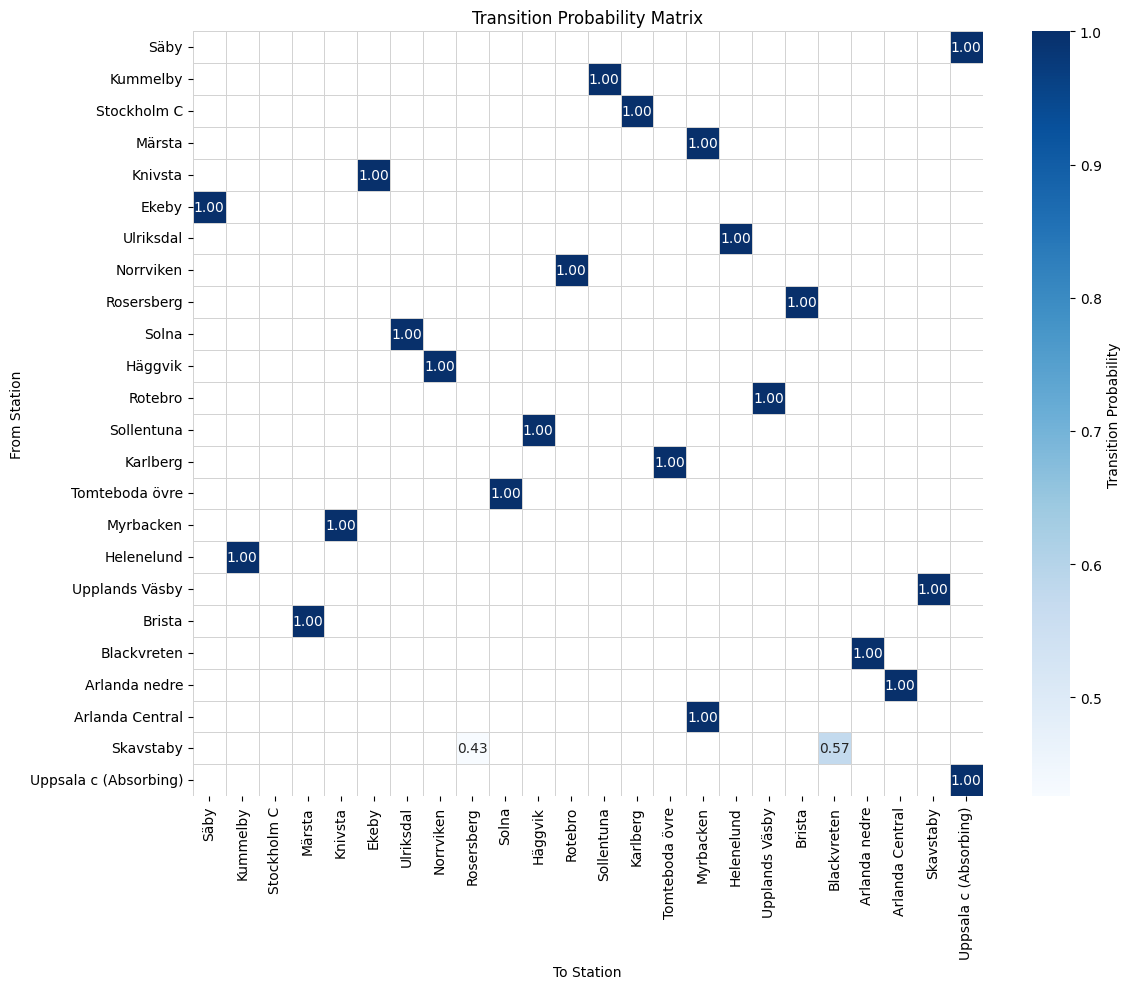

In [149]:
transition_probabilities=randomized_shortest_path_akamatsu(cost_matrix, 0,23,0.1)
df_transition= pd.DataFrame(transition_probabilities)
df_transition.columns = all_stations + [destination]
df_transition.index = all_stations + [destination]
df_transition = df_transition.rename(index={destination: destination + ' (Absorbing)'})
df_transition = df_transition.rename(columns={destination: destination + ' (Absorbing)'})

df_transition = df_transition.replace(0, np.nan)  # Replace 0 with NaN for better visualization
plt.figure(figsize=(12, 10))

sns.heatmap(df_transition, cmap='Blues', annot=True, fmt=".2f",
            linewidths=0.5, linecolor='lightgray', cbar_kws={'label': 'Transition Probability'})

plt.title('Transition Probability Matrix')
plt.xlabel('To Station')    
plt.ylabel('From Station')
plt.xticks(rotation=90)
plt.yticks(rotation=0)  
plt.tight_layout()
plt.show()


In [146]:
# Check cost matrix variability
print("Unique costs:", np.unique(cost_matrix[cost_matrix < 1e10]))  # Exclude infinity

# Last row should be [inf, inf, ..., 0] for absorbing state
print("Last row of cost_matrix:", cost_matrix[-1, :])

Unique costs: [1.65346535 1.75342466 1.81744422 1.93630573 1.97694524 2.01020408
 2.04152249 2.09119497 2.19791667 2.28947368 2.46296296 2.51709402
 2.69       2.70555556 3.16981132 3.70756646 3.97368421 4.27203065
 4.54973822 4.69426752 4.76351351 4.94927536 5.63478261 5.81578947]
Last row of cost_matrix: [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf]


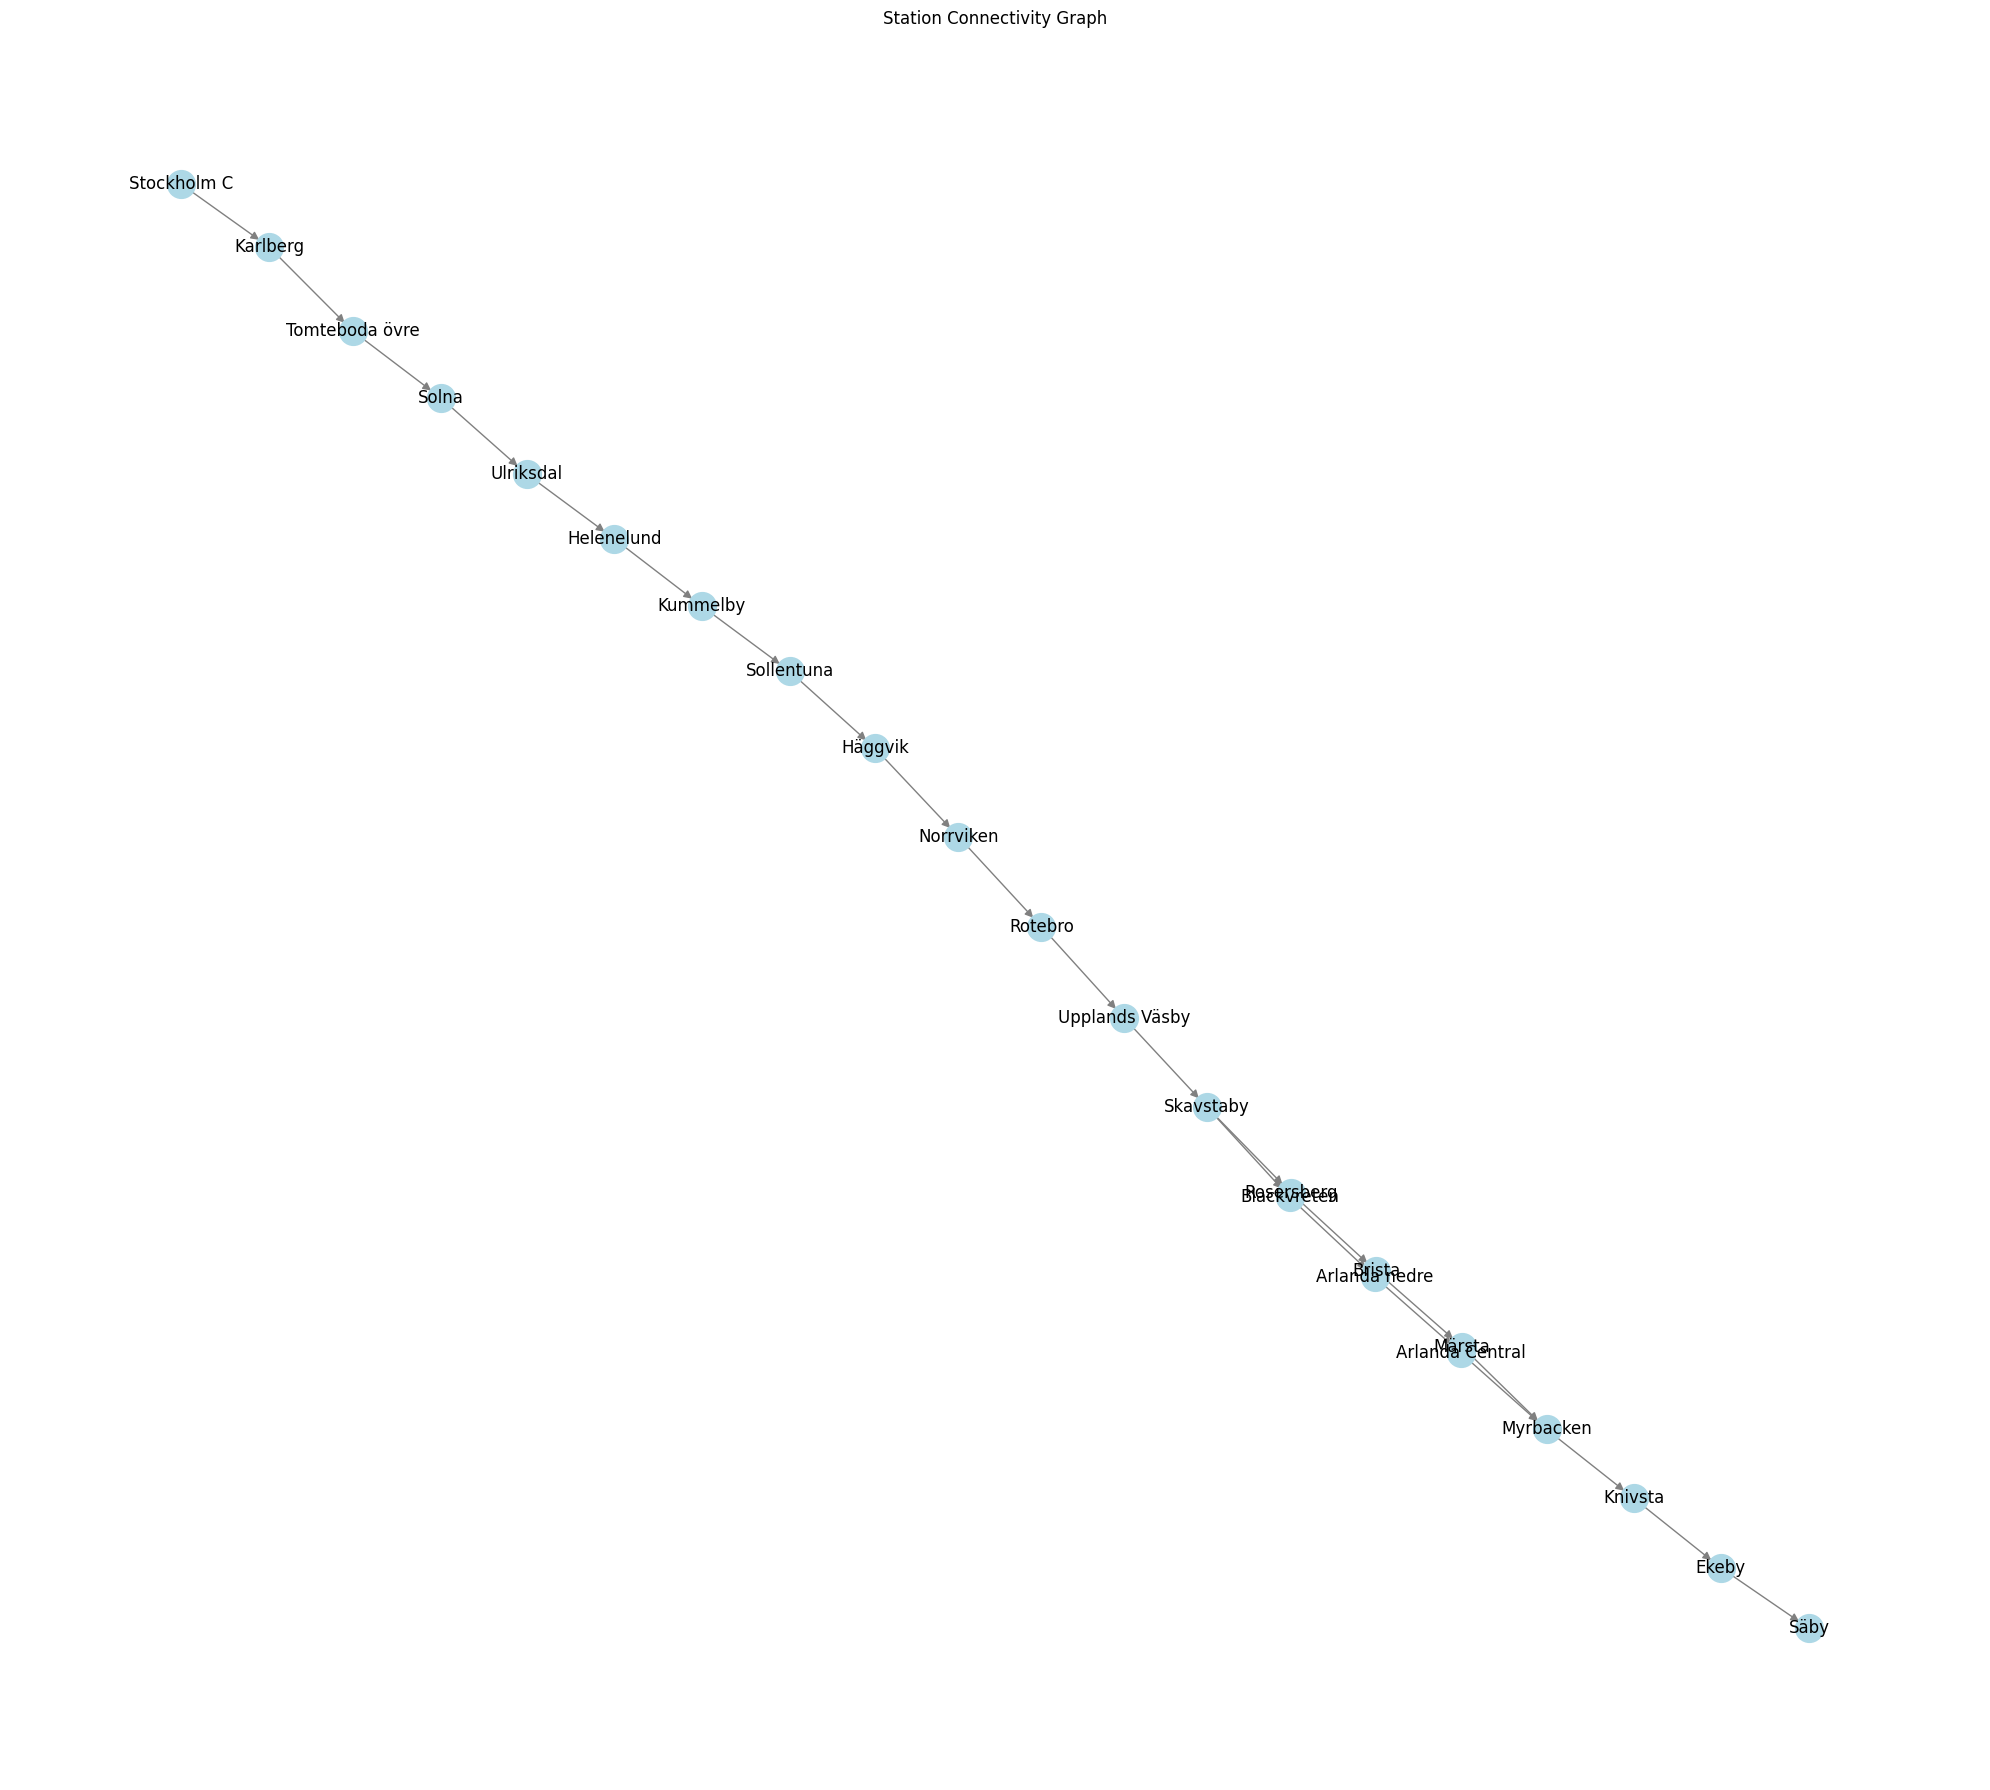

In [147]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Cst_to_U_Sorted.csv")

# Get adjacency matrix and station list
adj_matrix, stations = create_adjacency_matrix(df, destination_station="Uppsala c")

# Convert adjacency matrix to graph
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph())


# Create layout
pos = nx.kamada_kawai_layout(G)  # You can also try nx.kamada_kawai_layout(G)

# Draw nodes and edges
plt.figure(figsize=(20, 18))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=400)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=12)
nx.draw_networkx_labels(G, pos, font_size=12)

# Save to file
plt.title("Station Connectivity Graph", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.savefig("station_network.png", dpi=300)
plt.show()